# SKF LightGBM - Target Encoding

* LIBRARIES
* DATA
* TARGET ENCODING
* TIMER + CONFUSION MATRIX
* SKF LGBM + METRICS 
* PRED CSV

## 1. LIBRARIES

In [1]:
from collections import Counter
import category_encoders as ce
from datetime import timedelta 
from datetime import datetime
from scipy import interp
import pandas as pd
import numpy as np
import itertools
import warnings

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, auc
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

## 2. DATA

In [2]:
def read_data(file_path):
    print('Loading datasets...')
    train = pd.read_csv(file_path + "train.csv", sep=",")
    test = pd.read_csv(file_path + "test.csv", sep=",")
    print('Datasets loaded')
    return train, test

In [3]:
PATH = 'input/'
train, test = read_data(PATH)

Loading datasets...
Datasets loaded


In [4]:
### Zoom datasets 
def zoom_dataset(data):
    Count_missing_val = data.isnull().sum()
    Percent_missing = (data.isnull().sum()/data.isnull().count()*100)
    Percent_no_missing = 100 - Percent_missing
    Count_unique = data.nunique()
    Percent_unique_val = Count_unique / len(data)*100
    Type = data.dtypes
    data=[[i, Counter(data[i][data[i].notna()]).most_common(3)] for i in list(data)]
    top = pd.DataFrame(data, columns=['Name', 'Top_3']).set_index(['Name'])
    tt = pd.concat([Percent_no_missing, Count_missing_val, Percent_missing, Count_unique, Percent_unique_val, Type], axis=1, 
                   keys=['Percent_no_missing','Count_missing_val', 'Percent_missing', ' Count_unique', 'Percent_unique_val', 'Type'])
    tt = pd.concat([tt, top[['Top_3']]], axis=1, sort=False).reset_index()
    return((tt))

In [5]:
#overview train - test
for i in [train, test]:
    display(zoom_dataset(i))

Name  Percent_no_missing  Count_missing_val  Percent_missing  \
0       id          100.000000                  0         0.000000   
1    bin_0           97.017667              17894         2.982333   
2    bin_1           96.999500              18003         3.000500   
3    bin_2           97.011667              17930         2.988333   
4    bin_3           96.997667              18014         3.002333   
5    bin_4           96.992167              18047         3.007833   
6    nom_0           96.958000              18252         3.042000   
7    nom_1           96.974000              18156         3.026000   
8    nom_2           96.994167              18035         3.005833   
9    nom_3           96.979833              18121         3.020167   
10   nom_4           96.994167              18035         3.005833   
11   nom_5           97.037000              17778         2.963000   
12   nom_6           96.978167              18131         3.021833   
13   nom_7           96.999500              18003         3.000500   
14   nom_8           97.040833              17755         2.959167   
15   nom_9           96.987833              18073         3.012167   
16   ord_0           96.952000              18288         3.048000   
17   ord_1           96.993167              18041         3.006833   
18   ord_2           96.987500              18075         3.012500   
19   ord_3           97.014000              17916         2.986000   
20   ord_4           97.011667              17930         2.988333   
21   ord_5           97.047833              17713         2.952167   
22     day           97.008000              17952         2.992000   
23   month           97.002000              17988         2.998000   
24  target          100.000000                  0         0.000000   

     Count_unique  Percent_unique_val     Type  \
0          600000          100.000000    int64   
1               2            0.000333  float64   
2               2            0.000333  float64   
3               2            0.000333  float64   
4               2            0.000333   object   
5               2            0.000333   object   
6               3            0.000500   object   
7               6            0.001000   object   
8               6            0.001000   object   
9               6            0.001000   object   
10              4            0.000667   object   
11           1220            0.203333   object   
12           1519            0.253167   object   
13            222            0.037000   object   
14            222            0.037000   object   
15           2218            0.369667   object   
16              3            0.000500  float64   
17              5            0.000833   object   
18              6            0.001000   object   
19             15            0.002500   object   
20             26            0.004333   object   
21            190            0.031667   object   
22              7            0.001167  float64   
23             12            0.002000  float64   
24              2            0.000333    int64   

                                                Top_3  
0                            [(0, 1), (1, 1), (2, 1)]  
1                       [(0.0, 528377), (1.0, 53729)]  
2                      [(0.0, 474018), (1.0, 107979)]  
3                      [(0.0, 419845), (1.0, 162225)]  
4                          [(F, 366212), (T, 215774)]  
5                          [(N, 312344), (Y, 269609)]  
6     [(Red, 323286), (Blue, 205861), (Green, 52601)]  
7   [(Triangle, 164190), (Polygon, 152563), (Trape...  
8   [(Hamster, 164897), (Axolotl, 152319), (Lion, ...  
9   [(India, 164869), (Costa Rica, 151827), (Russi...  
10  [(Theremin, 308621), (Bassoon, 196639), (Oboe,...  
11  [(fc8fc7e56, 977), (360a16627, 972), (7917d446...  
12  [(ea8c5e181, 805), (9fa481341, 798), (2b94ada4...  
13  [(4ae48e857, 5035), (c79d2197d, 5031), (86ec76...  
14  [(7d7c02c57, 5052), (15f03b1f4, 4994), (

Name  Percent_no_missing  Count_missing_val  Percent_missing  \
0      id           100.00000                  0          0.00000   
1   bin_0            97.02475              11901          2.97525   
2   bin_1            96.99050              12038          3.00950   
3   bin_2            97.00700              11972          2.99300   
4   bin_3            97.01225              11951          2.98775   
5   bin_4            97.01225              11951          2.98775   
6   nom_0            96.98450              12062          3.01550   
7   nom_1            97.01325              11947          2.98675   
8   nom_2            96.95525              12179          3.04475   
9   nom_3            96.95600              12176          3.04400   
10  nom_4            97.00175              11993          2.99825   
11  nom_5            97.02200              11912          2.97800   
12  nom_6            96.99700              12012          3.00300   
13  nom_7            96.99925              12003          3.00075   
14  nom_8            97.01100              11956          2.98900   
15  nom_9            96.98500              12060          3.01500   
16  ord_0            97.02675              11893          2.97325   
17  ord_1            96.95825              12167          3.04175   
18  ord_2            96.97375              12105          3.02625   
19  ord_3            96.98675              12053          3.01325   
20  ord_4            97.01675              11933          2.98325   
21  ord_5            96.98825              12047          3.01175   
22    day            96.99375              12025          3.00625   
23  month            97.00400              11984          2.99600   

     Count_unique  Percent_unique_val     Type  \
0          400000           100.00000    int64   
1               2             0.00050  float64   
2               2             0.00050  float64   
3               2             0.00050  float64   
4               2             0.00050   object   
5               2             0.00050   object   
6               3             0.00075   object   
7               6             0.00150   object   
8               6             0.00150   object   
9               6             0.00150   object   
10              4             0.00100   object   
11           1219             0.30475   object   
12           1517             0.37925   object   
13            222             0.05550   object   
14            222             0.05550   object   
15           2216             0.55400   object   
16              3             0.00075  float64   
17              5             0.00125   object   
18              6             0.00150   object   
19             15             0.00375   object   
20             26             0.00650   object   
21            190             0.04750   object   
22              7             0.00175  float64   
23             12             0.00300  float64   

                                                Top_3  
0             [(600000, 1), (600001, 1), (600002, 1)]  
1                       [(0.0, 351777), (1.0, 36322)]  
2                       [(0.0, 315353), (1.0, 72609)]  
3                      [(0.0, 279998), (1.0, 108030)]  
4                          [(F, 244092), (T, 143957)]  
5                          [(N, 208427), (Y, 179622)]  
6     [(Red, 216452), (Blue, 136592), (Green, 34894)]  
7   [(Triangle, 109642), (Polygon, 101389), (Trape...  
8   [(Hamster, 109299), (Axolotl, 101836), (Lion, ...  
9   [(India, 109677), (Costa Rica, 101447), (Russi...  
10  [(Theremin, 205537), (Bassoon, 131465), (Oboe,...  
11  [(e32171484, 675), (360a16627, 661), (746554f5...  
12  [(4e161a54d, 554), (007c05fbd, 548), (822ea395...  
13  [(1dddb8473, 3394), (ba9faf5b1, 3331), (419014...  
14  [(d7e75499d, 3444), (5bdcf7324, 3339), (ef752c...  
15  [(3820773ae, 385), (f61c51337, 382), (146bbb38...  
16      [(1.0, 151659), (3.0, 132302), (2.0, 104146)]  
17  [(Novice, 106829

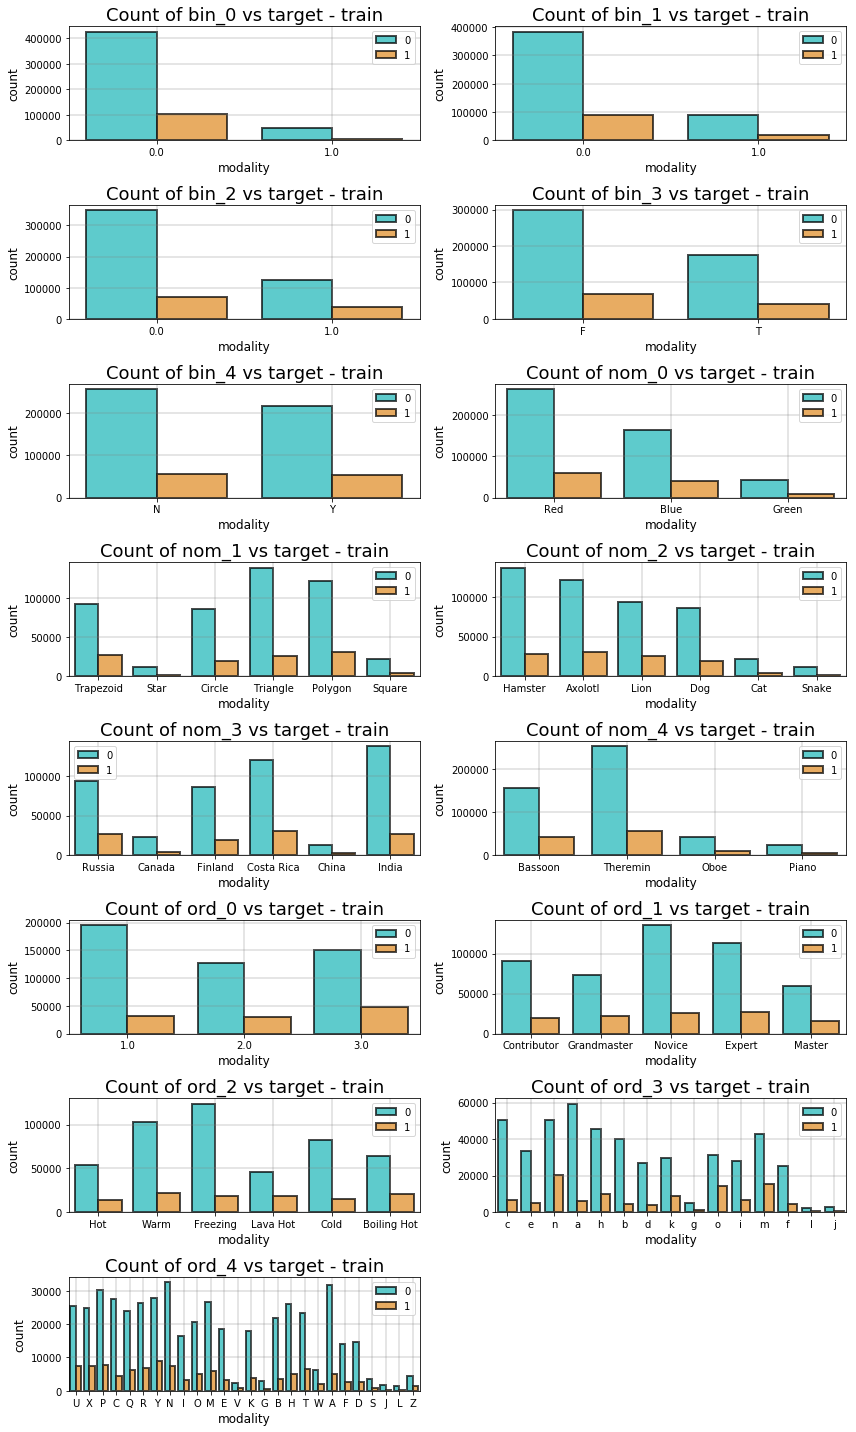

In [6]:
# train
f,ax=plt.subplots(8,2,figsize=(12,20))
f.delaxes(ax[7,1])

for i,feature in enumerate(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4']):
    colors = ['darkturquoise', 'darkorange']
    sns.countplot(x=feature,data=train,hue='target',ax=ax[i//2,i%2], palette = colors, alpha=0.7, edgecolor=('black'), linewidth=2)
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.4)
    ax[i//2,i%2].set_title('Count of {} vs target - train'.format(feature), fontsize=18)
    ax[i//2,i%2].legend(loc='best')
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('modality', fontsize=12)

plt.tight_layout()
plt.show()

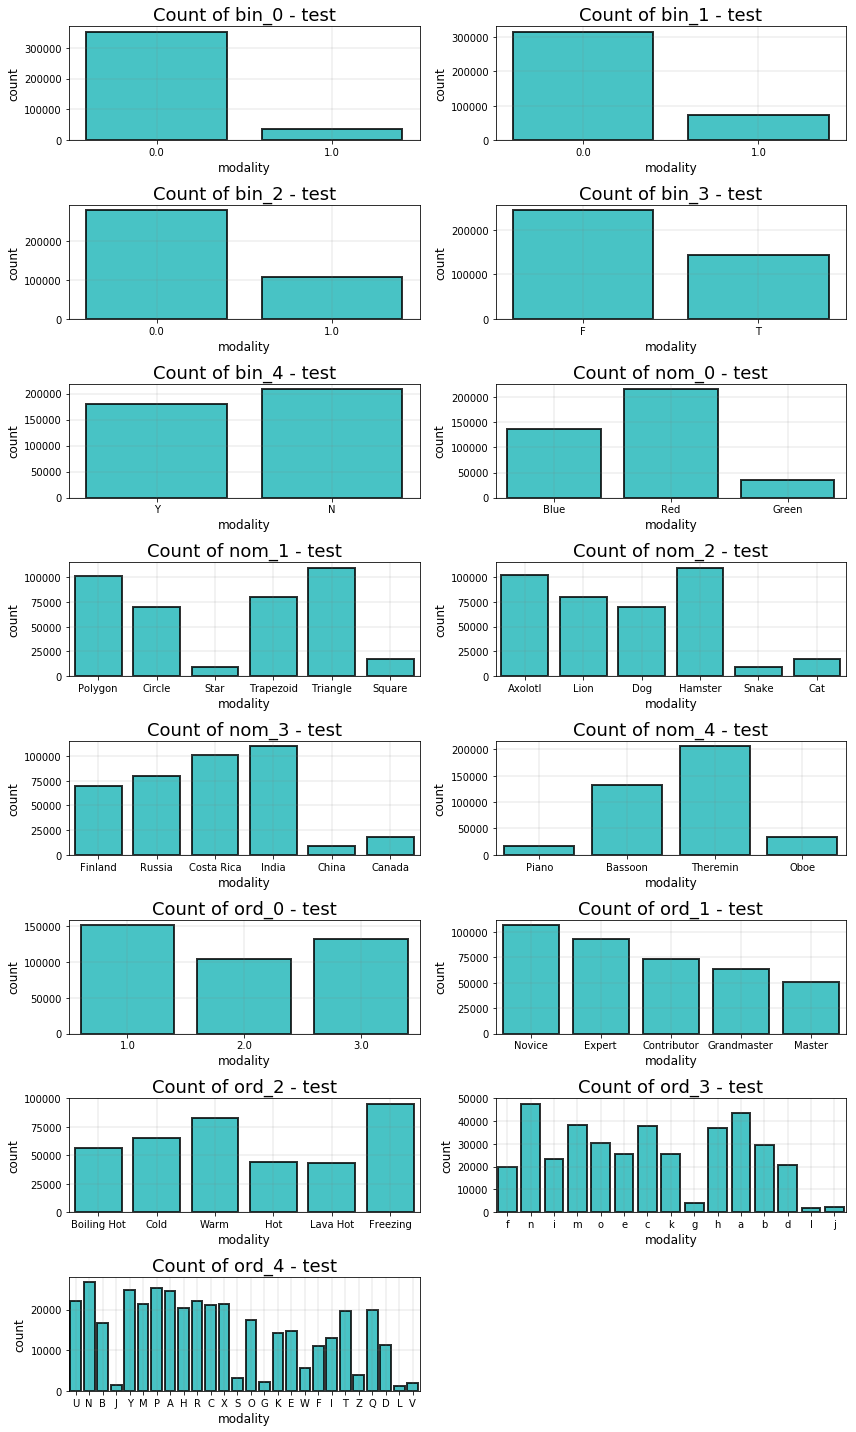

In [7]:
# test
f,ax=plt.subplots(8,2,figsize=(12,20))
f.delaxes(ax[7,1])

for i,feature in enumerate(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4']):
    colors = ['darkturquoise']
    sns.countplot(x=feature,data=test,ax=ax[i//2,i%2], palette = colors, alpha=0.8, edgecolor=('black'), linewidth=2)
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.2)
    ax[i//2,i%2].set_title('Count of {} - test'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('modality', fontsize=12)

plt.tight_layout()
plt.show()

## 3. TARGET ENCODING

In [8]:
# CREDITS : https://www.kaggle.com/caesarlupum/2020-20-lines-target-encoding
def encoding(train, test, smooth):
    print('Target encoding...')
    train.sort_index(inplace=True)
    target = train['target']
    test_id = test['id']
    train.drop(['target', 'id'], axis=1, inplace=True)
    test.drop('id', axis=1, inplace=True)
    cat_feat_to_encode = train.columns.tolist()
    smoothing=smooth
    oof = pd.DataFrame([])
    for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2020, shuffle=True).split(train, target):
        ce_target_encoder = ce.TargetEncoder(cols = cat_feat_to_encode, smoothing=smoothing)
        ce_target_encoder.fit(train.iloc[tr_idx, :], target.iloc[tr_idx])
        oof = oof.append(ce_target_encoder.transform(train.iloc[oof_idx, :]), ignore_index=False)
    ce_target_encoder = ce.TargetEncoder(cols = cat_feat_to_encode, smoothing=smoothing)
    ce_target_encoder.fit(train, target)
    train = oof.sort_index()
    test = ce_target_encoder.transform(test)
    features = list(train)
    print('Target encoding done!')
    return train, test, test_id, features, target

## 4. TIMER + CONFUSION MATRIX

In [9]:
# Timer
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Time taken : %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [10]:
# Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

## 5. SKF LGBM + METRICS

In [11]:
# model
def run_model(splits, features, target, train):
    # paramaters / hyperparameters
    model = lgb.LGBMClassifier(**{
                    'learning_rate': 0.05,
                    'feature_fraction': 0.1,
                    'min_data_in_leaf' : 12,
                    'max_depth': 3,
                    'reg_alpha': 1,
                    'reg_lambda': 1,
                    'objective': 'binary',
                    'metric': 'auc',
                    'n_jobs': -1,
                    'n_estimators' : 5000,
                    'feature_fraction_seed': 42,
                    'bagging_seed': 42,
                    'boosting_type': 'gbdt',
                    'verbose': 1,
                    'is_unbalance': True,
                    'boost_from_average': False})
    
    # Graph size
    plt.rcParams['figure.figsize']=(6,4)
    
    start_time = timer(None)

    print('LGBM modeling...')
    
    # Metrics / fold
    cms= []
    tprs = []
    aucs = []
    y_real = []
    y_proba = []
    recalls = []
    roc_aucs = []
    mean_tpr = []
    mean_fpr = []
    f1_scores = []
    accuracies = []
    precisions = []

    oof = np.zeros(len(train))
    mean_fpr = np.linspace(0,1,100)
    feature_importance_df = pd.DataFrame()
    i = 1
    
    # Statified K Fold + model
    folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print('Fold:', fold_ )
        model = model.fit(train.iloc[trn_idx][features], target.iloc[trn_idx],
                          eval_set = [(train.iloc[trn_idx][features], target.iloc[trn_idx]), 
                                      (train.iloc[val_idx][features], target.iloc[val_idx])],
                          verbose = 1000,
                          eval_metric = 'auc',
                          early_stopping_rounds = 1000)
        
        # oof
        oof[val_idx] =  model.predict_proba(train.iloc[val_idx][features])[:,1]
        
        # Roc curve / fold
        f = plt.figure(1)
        fpr, tpr, t = roc_curve(target[val_idx], oof[val_idx])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.5, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))

        # Precion recall / fold
        g = plt.figure(2)
        precision, recall, _ = precision_recall_curve(target[val_idx], oof[val_idx])
        y_real.append(target[val_idx])
        y_proba.append(oof[val_idx])
        plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  

        i= i+1

        # append metric by fold
        roc_aucs.append(roc_auc_score(target[val_idx], oof[val_idx]))
        accuracies.append(accuracy_score(target[val_idx], oof[val_idx].round()))
        recalls.append(recall_score(target[val_idx], oof[val_idx].round()))
        precisions.append(precision_score(target[val_idx], oof[val_idx].round()))
        f1_scores.append(f1_score(target[val_idx], oof[val_idx].round()))

        # Confusion matrix 
        cms.append(confusion_matrix(target[val_idx], oof[val_idx].round()))

    # Means
    print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores)))
    
    print('Modeling done!\n')
    
    # Timer end
    timer(start_time)
    
    return model, cms, tprs, aucs, y_real, y_proba, mean_fpr, mean_tpr, train

def graph_metrics(cms, tprs, aucs, y_real, y_proba, mean_fpr, mean_tpr):

    # Roc curve
    f = plt.figure(1)
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.4f)' % ((mean_auc)),lw=2, alpha=1)
    plt.grid(b=True, which='major', color='grey', linewidth=0.4)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('LGBM - ROC by folds', fontsize=18)
    plt.legend(loc="lower right")

    # Recall precision curve
    g = plt.figure(2)
    plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    plt.plot(recall, precision, color='blue',
             label=r'Mean P|R')
    plt.grid(b=True, which='major', color='grey', linewidth=0.4)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LGBM P|R curve by folds', fontsize=18)
    plt.legend(loc="lower left")

    # Confusion matrix
    plt.rcParams["axes.grid"] = False
    cm = np.average(cms, axis=0)
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='LGBM Confusion matrix [averaged/folds]')
    plt.show()

Target encoding...
Target encoding done!
LGBM modeling...
Fold: 0
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.791247	valid_1's auc: 0.786961
[2000]	valid_0's auc: 0.793213	valid_1's auc: 0.786894
Early stopping, best iteration is:
[1412]	valid_0's auc: 0.792111	valid_1's auc: 0.787008
Fold: 1
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.791155	valid_1's auc: 0.787462
[2000]	valid_0's auc: 0.7931	valid_1's auc: 0.78736
Early stopping, best iteration is:
[1258]	valid_0's auc: 0.791705	valid_1's auc: 0.787481
Fold: 2
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.791771	valid_1's auc: 0.785028
[2000]	valid_0's auc: 0.793678	valid_1's auc: 0.785006
Early stopping, best iteration is:
[1152]	valid_0's auc: 0.792101	valid_1's auc: 0.785068
Fold: 3
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.79064	valid_1's auc: 0.789379
[2000]	

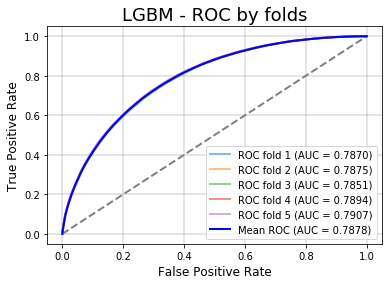

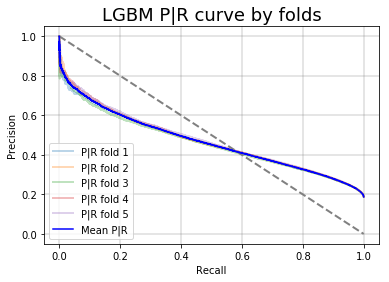

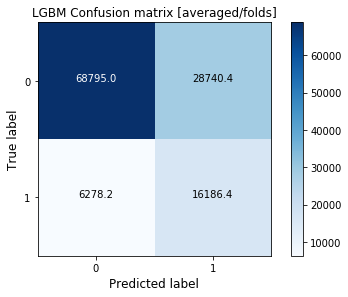

In [12]:
# Encoding
train, test, test_id, features, target = encoding(train, test, 0.3)
# Modeling
model, cms, tprs, aucs, y_real, y_proba, mean_fpr, mean_tpr, df_ml = run_model(5, features, target, train)
# Metrics + dataviz
graph_metrics(cms, tprs, aucs, y_real, y_proba, mean_fpr, mean_tpr)

## 6. PRED CSV

In [13]:
pd.DataFrame({'id': test_id, 'target': model.predict_proba(test)[:,1]}).to_csv('submission.csv', index=False)